# Group-Convolutional EDMD: A code-based introduction

This notebook serves as an exposition to the theoretical developments of a group-convolutional EDMD approach. It starts by loading the data, defining the group and its action, the generalized Fourier transform and its inverse, and finally demonstrates the use of convolution kernels for the prediction of the Kuramoto-Sivashinsky equation and the approximation of eigenfunctions of the Koopman operator. We tried to keep the implementation as close as possible to the written math, and hence tried to avoid any premature optimization.

### Importing packages and loading the data

The data is a trajectory generated by the [Kuramoto-Sivashinsky (KS) equation](https://en.wikipedia.org/wiki/Kuramoto%E2%80%93Sivashinsky_equation) in two spatial dimensions with periodic boundary conditions on the domain $\Omega = [0,3\pi) \times [0,3\pi)$. The domain is relatively small, and hence the normally chaotic behavior of the KS equation is very simple and tends to a periodic attractor. 
Our goal is to learn the system's flow using (group-convolutional) extended dynamic mode decomposition (EDMD).

We start by loading the data and plotting a few samples from the training trajectory.

n_samples = 10
state_dim = 256
some samples (viewed as (16, 16)):


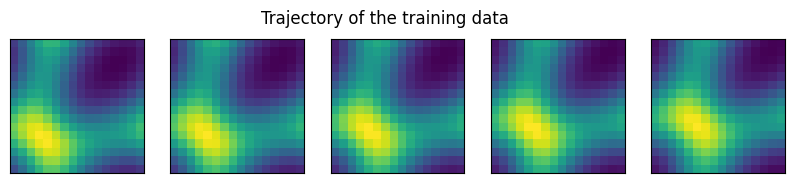

In [182]:
import torch
import numpy as np
from functools import partial
from random import choice
import matplotlib.pyplot as plt 
torch.set_default_dtype(torch.double)

# load training data
Y = torch.tensor( np.load("ks2d_long.npy") )
state_dim_orig = Y.shape[1:]
Y = Y.view(-1, Y.shape[1]*Y.shape[2])
n_samples = 10
Y_train = Y[900:900+n_samples+1,:]
Y_test  = Y[900+n_samples+1:,:]

# number of samples and the state dimension 
state_dim = Y_train.shape[1]
print(f"n_samples = {n_samples}")
print(f"state_dim = {state_dim}")

# plots a few samples
print(f"some samples (viewed as {tuple(state_dim_orig)}):")
n_plots = 5 
fig, ax = plt.subplots(1,n_plots,figsize=(10,2))
for j in range(n_plots):
    ax[j].matshow(Y_train[int(n_samples*(j/n_plots)),:].view(*state_dim_orig).numpy())
    ax[j].set_xticks([])
    ax[j].set_yticks([])
fig.suptitle(f"Trajectory of the training data")
plt.show()

## Definition of the group and its action on states

The next cell defines and demonstrates an action of the group $ G = \mathbb{Z}_4 \times \mathbb{Z}_4 $ on a given state $ y $, visualizing the original state, the transformed state under a group element $ g $, the reversion to the original state using the inverse $ g^{-1} $, and the identity operation through $ g^{-1}g $. The group elements are represented by tuples `(g0,g1)` for $g_0,g_1 = 0,\dots,3$. The group operation is defined by the function `op`, taking as input two group elements, and the function `inverse` which takes a group element and outputs its inverse. Finally, the function `act` defines the group's action on a state `y`, which is defined by periodic shifts along each of the two dimensions.

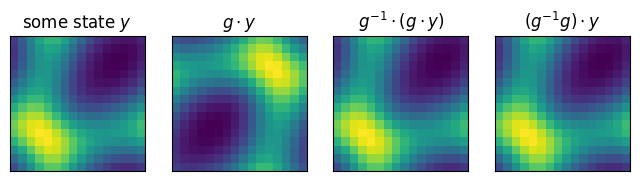

In [183]:
# defines the group G = Z_4 x Z_4
G = [ (g0, g1) for g0 in range(4) for g1 in range(4) ]

# defines the group operation
def op(g, h):
    return ( (g[0] + h[0]) % 4, (g[1] + h[1]) % 4 )

# returns the inverse of a group element g
def inverse(g):
    return ( (-g[0]) % 4, (-g[1]) % 4)

# defines a group action of a group element g=(g0,g1)  on a state y
def act(g, y):
    y_shape = y.shape
    y = y.view(-1, *state_dim_orig)
    y = torch.roll(y, -g[0]*round(state_dim_orig[0]/4), -2)
    y = torch.roll(y, -g[1]*round(state_dim_orig[1]/4), -1)
    y = y.view(*y_shape)
    return y

# plots an original state and its transformed version(s)
fig, ax = plt.subplots(1, 4, figsize=(8,2))
g = (2,2)
ax[0].matshow( Y_train[0,:].view(*state_dim_orig) )
ax[1].matshow( act(g, Y_train[0,:]).view(*state_dim_orig) )
ax[2].matshow( act(inverse(g), act(g, Y_train[0,:])).view(*state_dim_orig) )
ax[3].matshow( act( op(inverse(g), g), Y_train[0,:]).view(*state_dim_orig) )
ax[0].set_title("some state $y$")
ax[1].set_title("$g \cdot y$")
ax[2].set_title("$g^{-1} \cdot (g \cdot y)$")
ax[3].set_title("$(g^{-1} g) \cdot y$")
for i in range(4): 
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

## The generalized Fourier transform and its inverse

This code defines the generalized Fourier transform (GFT) and its inverse (iGFT). 
It first defines a set of *irreducible representations* given by $ \widehat{G} $, with `Ĝ` being a list of functions representing each $ \rho $ in $ \widehat{G} $. In this case, each representation $ \rho $ has a degree `d[ρ] = 1`, meaning all are one-dimensional (scalars), which could be used to simplify the computations in GFT and iGFT. (Which we do not do, however.)

**Fourier Transform (GFT)**: `GFT(u)` takes a mapping 
$$ 
    u : G \to \mathbb{C}^{n_1 \times \dots \times n_M},
$$ 
represented by a dictionary, and returns a new mapping where each input is a representation $ \rho \in \widehat{G} $,
$$ 
    \widehat{u}(\rho) \in \mathbb{C}^{n_1 \times \dots \times n_M \times d_\rho \times d_\rho}, \quad \widehat{u}_{i_1,\dots,i_M,\bullet,\bullet}(\rho)  = \sum_{g \in G} u_{i_1,\dots,i_M}(g) \rho(g).
$$
It effectively sums over $ h \in G $, weighting $ \rho(h) $ by $ u(h) $.

**Inverse Fourier Transform (iGFT)**: `iGFT(û)` reconstructs $ u $ from its Fourier-transformed components $ \widehat{u} $. For an input of shape 
$$
    \widehat{u}(\rho) \in \mathbb{C}^{n_1 \times \dots \times n_M \times d_\rho \times d_\rho}, 
$$
it outputs a dictionary 
$$
    u : G \rightarrow \mathbb C^{n_1\times \dots \times n_M},
    \quad u_{i_1,\dots,i_M}(g) = \frac{1}{|G|} \sum_{\rho \in \widehat G} d_\rho \mathrm{tr}(\rho(g^{-1}) \widehat{u}_{i_1,\dots,i_M,\bullet,\bullet}(\rho) )
$$

Finally, the code tests that applying `iGFT(GFT(u))` successfully reconstructs the original input dictionary $u$ for a randomly chosen group element $g$. The test output should confirm that `iGFT(GFT(u))[g]` closely matches `u[g]`.

In [184]:
# defines the irreducible representations and their degrees for this particular group
Rho = lambda h, g: torch.exp(-2j*torch.pi*( torch.tensor( g[0]*h[0]/4 + g[1]*h[1]/4) ) ).view(1,1)
Ĝ = [ partial(Rho, g=g) for g in G ]
d = { ρ: 1 for ρ in Ĝ }

# defines the generalized Fourier transform and its inverse
# it looks a bit complicated, but this is mainly due to the automatic broadcasting going on:
# GFT(u)      returns a dictionary mapping rho -> sum( u(h) * rho(h) )
# iGFT(û)     returns a dictionary mapping g -> (1/|G|) * sum( d_rho * tr( rho(g⁻¹) @ û(rho) ) )
def GFT(u):
    # takes some dictionary u : G -> ℂ^{n1 x ... x nM} 
    # and outputs a dictionary mapping Ĝ to: û[rho] ∈ ℂ^{n1 x ... x nM x d[rho] x d[rho]}
    u_shape = next(iter(u.values())).shape
    return  { ρ: sum( 
                    u[h].reshape(-1,d[ρ],d[ρ]) * ρ(h).reshape(1,d[ρ],d[ρ]) 
                for h in G).reshape(*u_shape, d[ρ], d[ρ]) 
            for ρ in Ĝ }

def iGFT(u_hat):
    # takes some dictionary mapping Ĝ to: û[rho] ∈ ℂ^{n1 x ... x nM x d[rho] x d[rho]}
    # and outputs a dictionary u : G -> ℂ^{n1 x ... x nM}
    u_shape = next(iter(u_hat.values())).shape[:-2]
    return  { g:   (1/len(G)) * sum( 
                    d[ρ] * torch.vmap(torch.trace)( 
                        ρ(inverse(g)) @ u_hat[ρ].reshape(-1,d[ρ],d[ρ]) 
                    ).reshape(u_shape) 
                for ρ in Ĝ ) 
            for g in G } 

# check if the GFT & inverse GFT work properly:
u = { g: torch.rand(3,3) for g in G }
û = GFT(u)
u_reconstruction = iGFT(û)
g = choice(G)
print(f"random group element: g = {g}\n")
print(f"original input u: u[g] =\n {u[g]}\n")
print(f"reconstruction from GFT: iGFT(GFT(u))[g] =\n {u_reconstruction[g].real}\n")

random group element: g = (2, 1)

original input u: u[g] =
 tensor([[0.6120, 0.3902, 0.5384],
        [0.1986, 0.4292, 0.8565],
        [0.9220, 0.0381, 0.7037]])

reconstruction from GFT: iGFT(GFT(u))[g] =
 tensor([[0.6120, 0.3902, 0.5384],
        [0.1986, 0.4292, 0.8565],
        [0.9220, 0.0381, 0.7037]])



# Extended dynamic mode decomposition

### Definition of the observables and the reconstruction matrix

This cell defines the *generating* observable $\chi$ by measuring the PDE's state at a number of `S` random points. Assuming that $x_1,\dots,x_{S}$ are these points, it is simply defined by:
$$
    \chi : Y \rightarrow \mathbb C^{S}, \quad \chi_i(y) = y(x_i).
$$
To obtain all base observables, we apply the group action with all possible group elements: For $g \in G$, we define $\psi(y) : G \rightarrow \mathbb C^{S}$ via
$$
    \psi(y) : g \mapsto \chi(g \cdot y). 
$$
(This is not exactly the same as in the paper, but nevertheless equivalent.) One can also view $\psi(y)$ as a *vector* in $\mathbb C^O$, where $O = S \times G$, via the mapping
$$
    \psi_{(s,g)}(y) = \chi_s(g\cdot y).
$$

Finally, we define a reconstruction matrix $B$ that solves the optimization problem
$$
    \argmin_{B \in \mathbb C^{n \times O}} \mathbb E [ \lVert B \psi(\bm y) - \bm  y \rVert^2] ,
$$
where $n$ is the state dimension and $\bm y \sim P_{\text{test}}$ is sampled from the test distribution. (This is a good way to check whether the system dynamics are reflected in the predictions of the (convolutional) EDMD approach.)

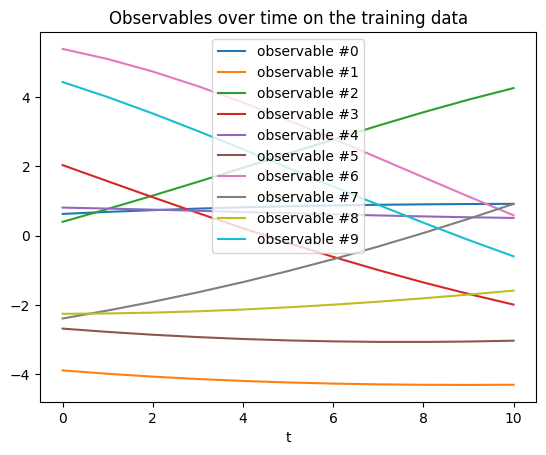

In [194]:
# defines the optimization problem: solves for the optimal EDMD convolution kernel
S = 10 # ( hence: S = { 1,2,..., n_S } )
torch.manual_seed(0)
measure_points = torch.randint(low=0,high=state_dim,size=(S,))

# defines a generating observable 
χ = lambda y: y[...,measure_points]+0j
# the correponding base observable
ψ_vec = lambda y: torch.cat([ χ( act(g, y) ) for g in G ], dim=-1)
# views ψ(y) as a function G -> ℂ^S instead of a vector ℂ^O (both are equivalent)
ψ = lambda y: { g: χ( act(g, y) ) for g in G } 

# the reconstruction matrix
B = torch.linalg.lstsq( ψ_vec(Y_test), Y_test+0j ).solution.T

# plots the evolution of the n_S observables over time
for i in range(S):
    plt.plot( χ( Y_train )[:,i].real, label=f"observable #{i}" )
plt.title("Observables over time on the training data")
plt.xlabel("t")
plt.legend()
plt.show()

### Group-Convolutional EDMD

We start by defining the convolution of a kernel $A : G \rightarrow \mathbb C^{S \times S}$ with a mapping $u : G \rightarrow \mathbb C^S$:

In [186]:

def convolve(A, u):
    # defines the convolution of a convolution kernel A : G -> ℂ^{n_S x n_S}
    # with an observation u: G -> ℂ^{n_S}
    return { g: sum( A[h] @ u[ op(inverse(h), g) ] for h in G )  for g in G }


#### Solving for the optimal convolution kernel

The following cell solves an optimization problem of the form
$$
    \min_{A : G \rightarrow \mathbb C^{S \times S}} \mathbb E[ \lVert A * \bm u  - \bm u^+ \rVert^2 ],
$$
where $\bm u, \bm u^+ : G \rightarrow \mathbb C^S$ are given random variables. This problem can be solved in Fourier space: In particular, we can individually solve optimization problems of the form
$$
    \min_{\widehat A(\rho) \in \mathbb C^{|S|d_\rho \times d_\rho}} \mathbb E[\lVert  \widehat A(\rho) \widehat {\bm u}(\rho) - \widehat{\bm u^+}(\rho) \rVert^2]
$$
for every $\rho \in \widehat G$. The kernel $A$ is then recovered by means of the inverse Fourier transform. 

Since we are in the EDMD setting, $\bm u$ is the observation of a state and $\bm u^+$ is the observation of its successor.

In [187]:
# now with enforced convolutional structure --> we learn a convolution kernel
def optimize(Y_in_train, Y_out_train):
    û = GFT(ψ(Y_in_train))
    û_plus = GFT(ψ(Y_out_train))

    Â = { }
    for ρ in Ĝ:
        # u_hat[ρ] (same for u_plus_hat[ρ]) is of shape n_samples x n_S x d[ρ] x d[ρ]
        # we have to reshape it into the form n_samples*d[ρ] x d[ρ]*n_S
        # this is because pytorch's lstsq multiplies the optimziation variable, Â[ρ], from the right
        û_ρ = û[ρ].transpose(1,3).reshape(n_samples*d[ρ], d[ρ]*S)
        û_plus_ρ = û_plus[ρ].transpose(1,3).reshape(n_samples*d[ρ], d[ρ]*S)

        # solves the optimization problem
        Â[ρ] = torch.linalg.lstsq( û_ρ, û_plus_ρ ).solution

        # due to pytorch's convention, we have to transpose the solution again
        Â[ρ] = Â[ρ].transpose(0, 1)
        Â[ρ] = Â[ρ].view( S, d[ρ], S, d[ρ] )

        # views A_hat[ρ] in the shape n_S x n_S x d[ρ] x d[ρ]
        # this is necessary for the inverse GFT, which treats the first few dimensions
        # as batch dimensions (up until the last two)
        Â[ρ] = Â[ρ].transpose(1, 2)

    # computes inverse GFT
    A = iGFT(Â)
    return A

#### Solving for the eigenpairs of a convolution kernel

Now, we would like to compute eigenvalue-eigenvector-pairs of the convolution 
$$
    u \mapsto A * u,
$$
where $u : G \rightarrow \mathbb C^S$ and $A : G \rightarrow \mathbb C^{S \times S}$. Again, this can be done in Fourier space:
For a fixed $\sigma \in \widehat G$, $j = 1,\dots,d_\rho$ and an eigenpair $(\lambda, \xi)$ of $\widehat A(\sigma)$, we obtain an eigenpair $(\lambda, v)$ for $u \mapsto A * u$ by specifying $v$ in Fourier space:
$$
    \widehat v (\rho) \in \mathbb C^{|S| d_\rho \times d_\rho}, \quad \widehat v_{\bullet, \ell} (\rho) = \begin{cases}
        \xi & \ell = j, \rho = \sigma \\
        0 & \text{else}
    \end{cases}
$$

In [188]:
# computing eigenpairs of the convolution u -> A * u
def eigenpairs(A):
    Â = GFT(A)
    # reshapes Â[ρ] into the form n_S*d[ρ] x n_S*d[ρ]
    Â = { ρ: Â[ρ].transpose(1,2).reshape(S*d[ρ], S*d[ρ]) for ρ in Ĝ }
    # then computes eigenpairs of Â[σ], for every σ in Ĝ
    eig = { σ: torch.linalg.eig(Â[σ]) for σ in Ĝ }
    # creates zero-padded versions of the eigenvectors
    for σ in Ĝ:
        eigvals, eigvecs = eig[σ] 
        for j in range(d[σ]):
            for λ, ξ in zip(eigvals, eigvecs.T):
                v_hat = { ρ: torch.zeros(S, d[ρ], d[ρ], dtype=torch.cdouble) for ρ in Ĝ }
                v_hat[σ][:,:,j] = ξ.view(S, d[σ])
                yield λ.item(), iGFT(v_hat)

#### Predicting the system's evolution...


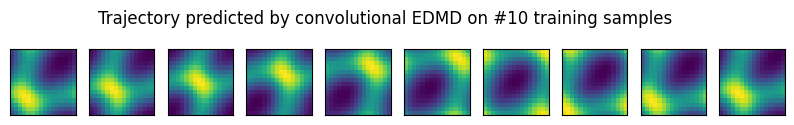

In [189]:
# solve for the optimal convolution kernel
A = optimize(Y_train[:-1], Y_train[1:])

T = 100 # solution time horizon
u0 = ψ(Y_train[0]) # initial observation
Y_pred_convolutional = torch.empty(T, state_dim) # stores state estimates
for t in range(T):
    # reconstruct state from estimated observation (this has no effect on the convolutional EDMD prediction)
    Y_pred_convolutional[t] = (B @ torch.cat( [u0[g] for g in G], dim = -1)).real 
    # advance the observation forward in time, using the learned convolution kernel
    u0 = convolve(A, u0)

# plot results
n_plots = 10
fig, ax = plt.subplots(1, n_plots, figsize=(10,1.5))
for k in range(n_plots):
    ax[k].matshow( Y_pred_convolutional[ int(k/n_plots*T) ].view(*state_dim_orig) )
    ax[k].set_xticks([])
    ax[k].set_yticks([])
fig.suptitle(f"Trajectory predicted by convolutional EDMD on #{n_samples} training samples")
plt.show()

### Computing and evaluating approximated eigenfunctions

In order to approximate eigenfunctions of the Koopman operator, we need to compute eigenpairs of the "transposed" convolution 
$
    u \mapsto A^T * u,
$
where 
$$
    A^T : G \rightarrow \mathbb C^{S \times S}, \quad A_{s,s'}(h) = A_{s',s}(h^{-1}).
$$
After constructing $A^T$, we compute eigenvectors of the convolution using the approach implemented above, i.e., we find pairs $(\lambda, v)$ satisfying 
$$
    A^T * v = \lambda v,
$$
where $v : G \rightarrow \mathbb C^S$. The resulting approximation to an eigenfunction of the Koopman operator is then:
$$
    f(y) = v^T \psi(y) = \sum_{(s,g) \in S \times G} v_{s}(g) \psi_{(s,g)}(y).
$$
The quality of this eigenfunction is evaluated with the squared relative residual (SRR),
$$
    \text{SRR}(\lambda, f) = 100 \% \cdot \frac{\mathbb E[| \mathcal K f(\bm y) - \lambda f(\bm y) |^2 ] } {\mathbb E [| f(\bm y) |^2] },
$$
where $\bm y \sim P_{\text{test}}$ is sampled from the test distribution.

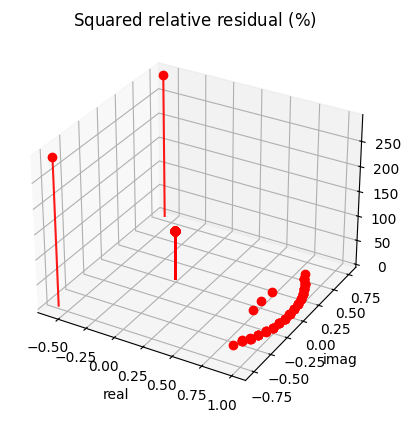

In [190]:
# defines the transposed convolution kernel
A_T = { g: A[inverse(g)].T for g in G }
SRRs_convolution = [ ]
for λ, v in eigenpairs(A_T): 
    v_vec = torch.cat([v[g] for g in G], dim=-1)
    top = ψ_vec(Y_test[1:]) @ v_vec - λ * ψ_vec(Y_test[:-1]) @ v_vec
    btm = ψ_vec(Y_test[:-1]) @ v_vec
    SRR = top.abs().pow(2).mean() / btm.abs().pow(2).mean()
    SRRs_convolution.append( (λ.real, λ.imag, 100 * SRR.item()) )

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
markerline, stemlines, baseline = ax.stem( *zip(*SRRs_convolution) )
markerline.set_color("red")
stemlines.set_color("red")
stemlines.set_alpha(0.9)
baseline.set_alpha(0)
ax.set_xlabel("real")
ax.set_ylabel("imag")
ax.set_title("Squared relative residual ($\%$)")
plt.show()

### Comparison: Classical EDMD

We compute the EDMD matrix and approximate the eigenfunctions in the usual way. 

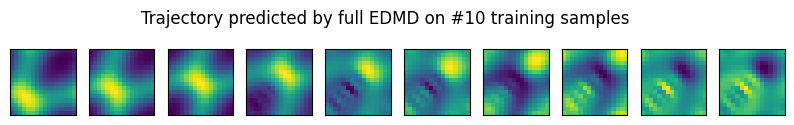

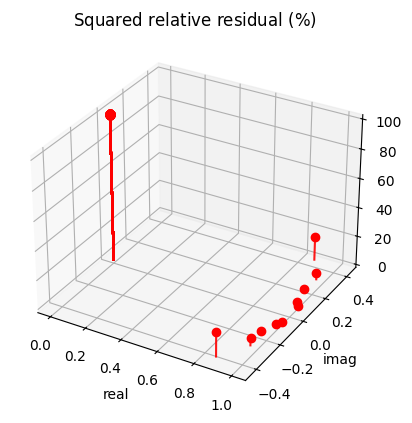

In [192]:
# the EDMD matrix 
K = torch.linalg.lstsq( ψ_vec(Y_train[:-1]), ψ_vec(Y_train[1:]) ).solution.T


# PREDICTING THE SYSTEM'S EVOLUTION
# predict a few time steps into the future
T = 100
u0 = ψ_vec(Y_train[0])
Y_pred_full = torch.empty(T, state_dim)
for t in range(T):
    Y_pred_full[t] = (B @ u0).real
    u0 = K @ u0

# plot results
n_plots = 10
fig, ax = plt.subplots(1, n_plots, figsize=(10,1.5))
for k in range(n_plots):
    ax[k].matshow( Y_pred_full[ int(k/n_plots*T) ].view(*state_dim_orig) )
    ax[k].set_xticks([])
    ax[k].set_yticks([])
fig.suptitle(f"Trajectory predicted by full EDMD on #{n_samples} training samples")
plt.show()

# EIGENFUNCTIONS
eigvals, eigvecs = torch.linalg.eig(K.T)

SRRs_full = [ ]
for λ, v in zip(eigvals, eigvecs.T):
    top = ψ_vec(Y_test[1:]) @ v - λ * ψ_vec(Y_test[:-1]) @ v
    btm = ψ_vec(Y_test[:-1]) @ v
    SRR = top.abs().pow(2).mean() / btm.abs().pow(2).mean()
    SRRs_full.append( (λ.real, λ.imag, 100 * SRR.item()) )

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
markerline, stemlines, baseline = ax.stem( *zip(*SRRs_full) )
markerline.set_color("red")
stemlines.set_color("red")
stemlines.set_alpha(0.9)
baseline.set_alpha(0)
ax.set_xlabel("real")
ax.set_ylabel("imag")
ax.set_title("Squared relative residual ($\%$)")
plt.show()